In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('/kaggle/input/movielens-20m-dataset/rating.csv')
df

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40
...,...,...,...,...
20000258,138493,68954,4.5,2009-11-13 15:42:00
20000259,138493,69526,4.5,2009-12-03 18:31:48
20000260,138493,69644,3.0,2009-12-07 18:10:57
20000261,138493,70286,5.0,2009-11-13 15:42:24


In [2]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

In [3]:
df

,userId,movieId,rating,timestamp
4182421,28507,1176,4.0,1995-01-09 11:46:44
18950979,131160,1079,3.0,1995-01-09 11:46:49
18950936,131160,47,5.0,1995-01-09 11:46:49
18950930,131160,21,3.0,1995-01-09 11:46:49
12341178,85252,45,3.0,1996-01-29 00:00:00
...,...,...,...,...
7819902,53930,118706,3.5,2015-03-31 06:00:51
2508834,16978,2093,3.5,2015-03-31 06:03:17
12898546,89081,55232,3.5,2015-03-31 06:11:26
12898527,89081,52458,4.0,2015-03-31 06:11:28


In [4]:
df['timestamp_int'] = df['timestamp'].values.astype(np.int64) // 10 ** 9
df.head()

,userId,movieId,rating,timestamp,timestamp_int
4182421,28507,1176,4.0,1995-01-09 11:46:44,789652004
18950979,131160,1079,3.0,1995-01-09 11:46:49,789652009
18950936,131160,47,5.0,1995-01-09 11:46:49,789652009
18950930,131160,21,3.0,1995-01-09 11:46:49,789652009
12341178,85252,45,3.0,1996-01-29 00:00:00,822873600


(array([ 239125.,  680732.,  279252., 1430997.,  883398., 4291193.,
        2200156., 5561926., 1534824., 2898660.]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <BarContainer object of 10 artists>)

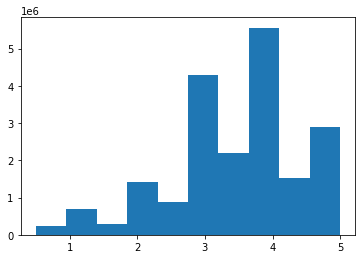

In [5]:
import matplotlib.pyplot as plt

plt.hist(df['rating'].values)

(array([1659326.,  984706., 3269908., 2069282., 2297922., 2946227.,
        2207941., 1810870., 1456931., 1297150.]),
 array([7.89652004e+08, 8.53465204e+08, 9.17278404e+08, 9.81091603e+08,
        1.04490480e+09, 1.10871800e+09, 1.17253120e+09, 1.23634440e+09,
        1.30015760e+09, 1.36397080e+09, 1.42778400e+09]),
 <BarContainer object of 10 artists>)

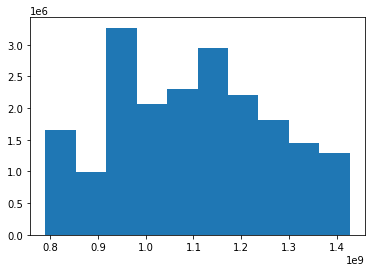

In [6]:
plt.hist(df['timestamp_int'].values)

In [7]:
df = df.rename(columns={"userId": "userId:token", "movieId": "movieId:token", "timestamp_int": "timestamp:float"})


In [8]:
df.head()

,userId:token,movieId:token,rating,timestamp,timestamp:float
4182421,28507,1176,4.0,1995-01-09 11:46:44,789652004
18950979,131160,1079,3.0,1995-01-09 11:46:49,789652009
18950936,131160,47,5.0,1995-01-09 11:46:49,789652009
18950930,131160,21,3.0,1995-01-09 11:46:49,789652009
12341178,85252,45,3.0,1996-01-29 00:00:00,822873600


In [9]:
test_part = 0.2
train_len = int(df.shape[0] * (1 - test_part))
test_len = df.shape[0] - train_len 
df_train, df_test = df.drop(['timestamp'], axis=1).head(train_len), df.drop(['timestamp'], axis=1).tail(test_len)

In [10]:
df_train.head()

,userId:token,movieId:token,rating,timestamp:float
4182421,28507,1176,4.0,789652004
18950979,131160,1079,3.0,789652009
18950936,131160,47,5.0,789652009
18950930,131160,21,3.0,789652009
12341178,85252,45,3.0,822873600


(array([1658022., 1603648., 1556707., 1587068., 1582019., 1645064.,
        1602175., 1585145., 1604241., 1576121.]),
 array([1.000000e+00, 1.385020e+04, 2.769940e+04, 4.154860e+04,
        5.539780e+04, 6.924700e+04, 8.309620e+04, 9.694540e+04,
        1.107946e+05, 1.246438e+05, 1.384930e+05]),
 <BarContainer object of 10 artists>)

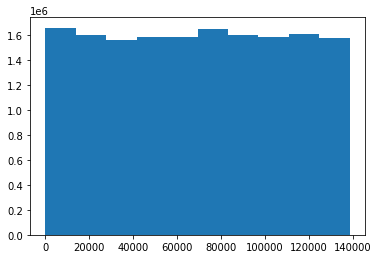

In [11]:
plt.hist(df_train['userId:token'].values)

In [12]:
df['userId:token'].min(), df['userId:token'].max(), df['movieId:token'].min(), df['movieId:token'].max()

(1, 138493, 1, 131262)

In [13]:
import torch

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [14]:
import torch
import torch.nn as nn
from tqdm.auto import trange
import random


class LMDataset(torch.utils.data.Dataset):
    def __init__(self, df, n_users_total, n_items_total, batch_size, max_len):
        self.n_users_total = n_users_total
        self.n_items_total = n_items_total
        self.batch_size = batch_size
        self.users_history = [[] for _ in range(self.n_users_total)]
        self.max_len = max_len
        for i in trange(df.shape[0]):
            cur_user = df['userId:token'].iloc[i]
            cur_item = df['movieId:token'].iloc[i]
            cur_rating = df['rating'].iloc[i]
            cur_ts = df['timestamp:float'].iloc[i]
            self.users_history[cur_user].append((cur_item, cur_rating, cur_ts))
        

    def __getitem__(self, index):
        batch_users = set()
        while len(batch_users) < self.batch_size:
            v = random.randint(0, self.n_users_total) - 1
            if v not in batch_users:
               batch_users.add(v)
        batch_users = list(batch_users)
        max_len = 0
        for u in batch_users:
            max_len = max(max_len, len(self.users_history[u]))
        max_len = min(max_len, self.max_len)
        history_input, history_output, mask = torch.zeros((self.batch_size, max_len + 1), dtype=torch.long), \
                                              torch.zeros((self.batch_size, max_len + 1), dtype=torch.long), \
                                              torch.zeros((self.batch_size, max_len + 1), dtype=torch.long)
        metadata = torch.zeros((self.batch_size, max_len + 1, 2))
        for i, u in enumerate(batch_users):
            for j in range(min(self.max_len,len(self.users_history[u]))):
                cur_item, cur_rating, cur_ts = self.users_history[u][j]
                history_input[i][j + 1] = cur_item
                history_output[i][j] = cur_item
                mask[i][j] = 1
                metadata[i][j + 1][0] = cur_rating
                metadata[i][j + 1][1] = cur_ts
        return {
            "history_input" : history_input.to(device),
            "history_output": history_output.to(device),
            "mask" : mask.to(device),
            "metadata": metadata.to(device)
        }

    def __len__(self):
        return self.n_users_total // self.batch_size + 1



In [15]:
train_dataset = LMDataset(df_train, df['userId:token'].max() + 1, df['movieId:token'].max() + 1, 8, 140)

  0%|          | 0/16000210 [00:00<?, ?it/s]

In [16]:
train_dataset[0]

{'history_input': tensor([[   0,    0,    0,  ...,    0,    0,    0],
         [   0, 2054,  173,  ...,    0,    0,    0],
         [   0,  380,  296,  ...,    0,    0,    0],
         ...,
         [   0,  356, 2694,  ...,    0,    0,    0],
         [   0, 4776, 1194,  ...,    0,    0,    0],
         [   0, 2762, 2858,  ..., 4029, 2539, 3793]], device='cuda:0'),
 'history_output': tensor([[   0,    0,    0,  ...,    0,    0,    0],
         [2054,  173, 1485,  ...,    0,    0,    0],
         [ 380,  296,  592,  ...,    0,    0,    0],
         ...,
         [ 356, 2694, 2183,  ...,    0,    0,    0],
         [4776, 1194, 1357,  ...,    0,    0,    0],
         [2762, 2858, 2707,  ..., 2539, 3793,    0]], device='cuda:0'),
 'mask': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 0]], device='cuda:0'),
 'metadata':

In [17]:
class BERT4Rec(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_dim, num_layers, hidden_size, output_items, max_len):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.additional_info_encoding = nn.Linear(2, embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=4)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.last = nn.Linear(embedding_dim, output_items)
        self.positional_encoding = nn.Parameter(torch.randn(1, max_len, embedding_dim))
        self.max_len = max_len

    def forward(self, history_input, metadata):
        positional_encoding = torch.cat([self.positional_encoding[:, :history_input.shape[1],:]] * history_input.shape[0], 0)
        hidden = self.embedding(history_input) + self.additional_info_encoding(metadata) + positional_encoding
        output_gru = self.transformer(hidden)
        return self.last(output_gru)

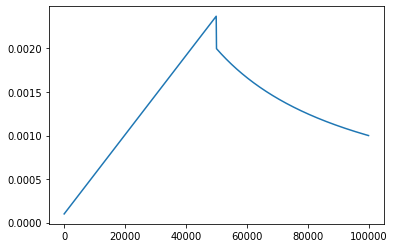

In [18]:
def lr_func(iteration):
    if iteration < 50000:
        return 5e-5 * (2 + iteration / 1100)
    else:
        return 100 / iteration
    
xs = np.linspace(0, 100000, 1000)
ys = [lr_func(x) for x in xs]

plt.plot(xs, ys);


In [19]:
model = BERT4Rec(df['movieId:token'].max() + 1, 64, 64, 2, 64, df['movieId:token'].max() + 1, 150).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lr_func])
criterion = nn.CrossEntropyLoss()

In [20]:
from tqdm.auto import trange, tqdm 

epochs = 15

history = []

for _ in trange(epochs):
    pbar = trange(len(train_dataset))
    for i in pbar:
        batch = train_dataset[i]

        mask = torch.randn(batch['history_input'].shape).ge(0.5).to(device)
        inv_mask = ~mask
        optimizer.zero_grad()
        output_model = model(batch['history_input'] * inv_mask, batch['metadata'])
        output_dim = output_model.shape[-1]
        loss = criterion(output_model[mask].reshape(-1, output_dim), batch['history_input'][mask].reshape(-1))

        history.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/17312 [00:00<?, ?it/s]

  0%|          | 0/17312 [00:00<?, ?it/s]

  0%|          | 0/17312 [00:00<?, ?it/s]

  0%|          | 0/17312 [00:00<?, ?it/s]

  0%|          | 0/17312 [00:00<?, ?it/s]

  0%|          | 0/17312 [00:00<?, ?it/s]

  0%|          | 0/17312 [00:00<?, ?it/s]

  0%|          | 0/17312 [00:00<?, ?it/s]

  0%|          | 0/17312 [00:00<?, ?it/s]

  0%|          | 0/17312 [00:00<?, ?it/s]

  0%|          | 0/17312 [00:00<?, ?it/s]

  0%|          | 0/17312 [00:00<?, ?it/s]

  0%|          | 0/17312 [00:00<?, ?it/s]

  0%|          | 0/17312 [00:00<?, ?it/s]

  0%|          | 0/17312 [00:00<?, ?it/s]

In [21]:
torch.save(model, 'model.pt')

In [22]:
import pickle
with open("metrics.txt", 'wb') as f:
    pickle.dump(history, f)


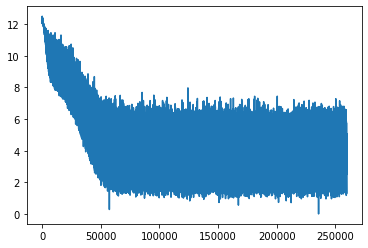

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(len(history)), history)

In [24]:
@torch.no_grad()
def reccomend_for_user(user_id, k):
    h_len = model.max_len - k
    users_history = train_dataset.users_history[user_id][-h_len:]
    answer = []
    mark = 5.0
    ts = users_history[-1][2] if len(users_history) > 0 else 0

    for i in range(k):
        users_history.append((0, mark, ts))

    max_len = len(users_history)
    history_input = torch.zeros((1, max_len), dtype=torch.long).to(device)
    metadata = torch.zeros((1, max_len, 2)).to(device)
    for j in range(len(users_history)):
        cur_item, cur_rating, cur_ts = users_history[j]
        history_input[0][j] = cur_item
        metadata[0][j][0] = cur_rating
        metadata[0][j][1] = cur_ts
    output = model(history_input, metadata)[0][-k:][1:].argmax(-1).reshape(-1)
    answer = list(output.cpu().detach().numpy())
    return answer

In [25]:
from math import log2

def apk(pred, target, k):
    if len(pred) >= k:
        pred = pred[:k]

    ans, cnt = 0, 0
    tot = len(pred) 
    s = set()
    for i in range(len(pred)):
        if pred[i] in target and pred[i] not in s:
            cnt += 1
            ans += cnt / (i + 1)
            s.add(pred[i])
    return ans / tot


def mapk(pred, target, k):
    assert len(pred) == len(target)
    sum_metric = 0
    for cur_pred, cur_target in zip(pred, target):
        sum_metric += apk(cur_pred, cur_target, k)
    return sum_metric / len(pred) 


def mr(pred, target):
    ans, cnt = 0, 0
    tot = len(pred)
    s = set()
    for i in range(len(pred)):
        if pred[i] in target and pred[i] not in s:
            ans += 1 / (i + 1)
            s.add(pred[i])
            break
    return ans

def mrr(pred, target):
    assert len(pred) == len(target)
    sum_metric = 0
    for cur_pred, cur_target in zip(pred, target):
        sum_metric += mr(cur_pred, cur_target)
    return sum_metric / len(pred) 


def ndcgunique(pred, target):
    ans, cnt = 0, 0
    tot = len(pred)
    s = set()
    for i in range(len(pred)):
        if pred[i] in target and pred[i] not in s:
            ans += 1 / (log2(i + 2))
            s.add(pred[i])
    return ans / tot

def ndcg(pred, target):
    assert len(pred) == len(target)
    sum_metric = 0
    for cur_pred, cur_target in zip(pred, target):
        sum_metric += ndcgunique(cur_pred, cur_target)
    return sum_metric / len(pred) 


def precisionunique(pred, target, k):
    if len(pred) >= k:
        pred = pred[:k]

    ans, cnt = 0, 0
    tot = len(pred)
    s = set()
    for i in range(len(pred)):
        if pred[i] in target and pred[i] not in s:
            ans += 1
            s.add(pred[i])
    return ans / tot


def precision(pred, target, k):
    assert len(pred) == len(target)
    sum_metric = 0
    for cur_pred, cur_target in zip(pred, target):
        sum_metric += precisionunique(cur_pred, cur_target, k)
    return sum_metric / len(pred) 

In [26]:
test_dataset = LMDataset(df_test, df['userId:token'].max() + 1, df['movieId:token'].max() + 1, 32, 140)

  0%|          | 0/4000053 [00:00<?, ?it/s]

In [27]:
predictions = []
target = []
k = 20
for i in trange(len(test_dataset.users_history)):
    if len(test_dataset.users_history[i]) == 0:
        continue
    out = reccomend_for_user(i, k)
    predictions.append(out)
    target.append([x[0] for x in test_dataset.users_history[i]])

  0%|          | 0/138494 [00:00<?, ?it/s]

In [28]:
for i in range(1, 20):
    print(f"precision@{i} : {precision(predictions, target, i)}")
print(f"ndcg: {ndcg(predictions, target)}")
print(f"mrr: {mrr(predictions, target)}")
for i in range(1, 20):
    print(f"mapk@{i} : {mapk(predictions, target, i)}")

precision@1 : 0.017650773602778655
precision@2 : 0.013782759709504263
precision@3 : 0.011746131986106682
precision@4 : 0.01025418377012946
precision@5 : 0.00906220397852847
precision@6 : 0.008262288180191512
precision@7 : 0.007560106454959538
precision@8 : 0.0068913798547521315
precision@9 : 0.006437918815563388
precision@10 : 0.00603094411114611
precision@11 : 0.005672130206389841
precision@12 : 0.0053415429954741765
precision@13 : 0.005069102037842195
precision@14 : 0.0048197934052054674
precision@15 : 0.004578465424692129
precision@16 : 0.004353489106409852
precision@17 : 0.004175411876149348
precision@18 : 0.004011858400870153
precision@19 : 0.0038439167068287073
ndcg: 0.002105825207556984
mrr: 0.024133707039912054
mapk@1 : 0.017650773602778655
mapk@2 : 0.01225923586990843
mapk@3 : 0.009530575728870623
mapk@4 : 0.007799179033785923
mapk@5 : 0.006572781812440758
mapk@6 : 0.005695716240395729
mapk@7 : 0.005014144590580145
mapk@8 : 0.004458915039018449
mapk@9 : 0.0040297498620306986
m

In [29]:
for i in range(1, 40):
    print(f"precision@{i} : {precision(target, target, i)}")
print(f"ndcg: {ndcg(target, target)}")
print(f"mrr: {mrr(target, target)}")
for i in range(1, 40):
    print(f"mapk@{i} : {mapk(target, target, i)}")

precision@1 : 1.0
precision@2 : 1.0
precision@3 : 1.0
precision@4 : 1.0
precision@5 : 1.0
precision@6 : 1.0
precision@7 : 1.0
precision@8 : 1.0
precision@9 : 1.0
precision@10 : 1.0
precision@11 : 1.0
precision@12 : 1.0
precision@13 : 1.0
precision@14 : 1.0
precision@15 : 1.0
precision@16 : 1.0
precision@17 : 1.0
precision@18 : 1.0
precision@19 : 1.0
precision@20 : 1.0
precision@21 : 1.0
precision@22 : 1.0
precision@23 : 1.0
precision@24 : 1.0
precision@25 : 1.0
precision@26 : 1.0
precision@27 : 1.0
precision@28 : 1.0
precision@29 : 1.0
precision@30 : 1.0
precision@31 : 1.0
precision@32 : 1.0
precision@33 : 1.0
precision@34 : 1.0
precision@35 : 1.0
precision@36 : 1.0
precision@37 : 1.0
precision@38 : 1.0
precision@39 : 1.0
ndcg: 0.25948577327982253
mrr: 1.0
mapk@1 : 1.0
mapk@2 : 1.0
mapk@3 : 1.0
mapk@4 : 1.0
mapk@5 : 1.0
mapk@6 : 1.0
mapk@7 : 1.0
mapk@8 : 1.0
mapk@9 : 1.0
mapk@10 : 1.0
mapk@11 : 1.0
mapk@12 : 1.0
mapk@13 : 1.0
mapk@14 : 1.0
mapk@15 : 1.0
mapk@16 : 1.0
mapk@17 : 1.0
mapk